In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from time import gmtime, strftime, sleep
from scipy import interpolate as interp
from scipy import signal
import os
import random
import rawpy
import cv2 

import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, TimeDistributed, BatchNormalization, Activation, Average, Lambda, Reshape, Concatenate, Conv2DTranspose, UpSampling2D, average, LeakyReLU
from keras.layers.core import Activation
from keras.layers.convolutional import Conv1D, Conv2D, Conv3D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, MaxPooling3D
from keras import optimizers
from keras.utils import np_utils, generic_utils



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/usr/local/lib/python3.7/site-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')
/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def loadDataset(dpath,  dI, dispI = 1):
    fids = sorted(os.listdir(dpath+dI+'/'))
    print ('   Number of fids: '+str(len(fids)))
    patchSize = 128
    img = mpimg.imread(dpath+dI+'/'+fids[0])
    totNpatches = len(fids)*np.shape(img)[0]//patchSize*np.shape(img)[1]//patchSize*len(fids)
    count = 0
    scaleX = 0.5
    scaleY = 0.5
    patches = np.zeros((totNpatches, patchSize, patchSize,3))
    patchesLR = np.zeros((totNpatches, patchSize//2, patchSize//2,3))
    mosaic_patches = np.zeros((totNpatches, patchSize//2, patchSize//2))
    for i in range(len(fids)):
        if dispI ==1:
            plt.figure(i)
        fcount = 1
        img = mpimg.imread(dpath+dI+'/'+fids[i])
#         img = cv2.imread(dpath+dI+'/'+fids[i])
        
#         print ('img shape: '+ str(img.shape))
        for j in range(0,np.shape(img)[0]-patchSize+1,patchSize):
            for k in range(0,np.shape(img)[1]-patchSize+1,patchSize):
#                 print (str(j)+', '+str(k))
                patches[count,] = img[j:j+patchSize,k:k+patchSize,:]
#                 plt.figure(1)
#                 plt.imshow(patches[count,])
#                 plt.show()
#                 print ('patches shape: '+ str(patches[count,].shape))
                patchesLR[count,] = cv2.resize(patches[count,],  (0,0), fx=scaleX,fy=scaleY, interpolation = cv2.INTER_CUBIC)
#                 plt.figure(2)
#                 plt.imshow(patchesLR[count,])
#                 plt.show()
#                 print ('patchesLR shape: '+ str(patchesLR[count,].shape))
                mosaic_patches[count,] = mosaic(patchesLR[count])
#                 plt.figure(3)
#                 plt.imshow(mosaic_patches[count,])
#                 plt.show()
# #                 print ('mosaic_patches shape: '+ str(np.shape(mosaic_patches[count])))
#                 if dispI ==1:
#                     plt.subplot(np.shape(img)[0]//patchSize,np.shape(img)[1]//patchSize,fcount)
#                     plt.imshow(patches[count])
#                     fcount = fcount+1
                    
                    
#                     plt.imshow(mosaic_patches[count,])
#                     plt.show()
                count = count+1
#         plt.show()
    patches = patches[0:count,]
    patchesLR = patchesLR[0:count,]
    mosaic_patches = mosaic_patches[0:count,]
    print ('   patchesSR shape: '+str(np.shape(patches)))
    print ('   patchesLR shape: '+str(np.shape(patchesLR)))
    print ('   mosaic_patches shape: '+str(np.shape(mosaic_patches)))
    print ('Done.')
    return patches, patchesLR, mosaic_patches
    
def mosaic(img, dispI = 0):
    red = np.copy(img[:,:,0])
    red[0::2,1::2] = 0
    red[1::2,:] = 0
    green = np.copy(img[:,:,1])
    green[0::2,0::2] = 0
    green[1::2,1::2] = 0
    blue = np.copy(img[:,:,2])
    blue[0::2,:] = 0
    blue[1::2,0::2] = 0
    if dispI ==1:
        print (red.shape)
        print (green.shape)
        print (blue.shape)
        plt.figure(1)
        plt.subplot(1,3,1)
        plt.imshow(red)
        plt.title('Red')
        plt.subplot(1,3,2)
        plt.imshow(green)
        plt.title('Green')
        plt.subplot(1,3,3)
        plt.imshow(blue)
        plt.title('Blue') 
        plt.show()
    return red+green+blue

In [6]:
dpath = 'SR_testing_datasets/'
dids = sorted(os.listdir(dpath))
fidN = 0
for dI in dids:
    if dI =='.DS_Store':
        continue
    fids = sorted(os.listdir(dpath+dI+'/'))
    fidN = fidN +len(fids)
    print (dI+': '+str(len(fids)))
print (fidN)
print (dids)

BSDS100: 100
CLIC: 41
DIV2K_valid_HR: 100
Manga109: 109
Set14: 14
Set5: 5
Urban100: 100
historical: 1
470
['.DS_Store', 'BSDS100', 'CLIC', 'DIV2K_valid_HR', 'Manga109', 'Set14', 'Set5', 'Urban100', 'historical']


In [12]:
dispI = 0
dpath = 'SR_training_datasets/'
dpath = 'SR_testing_datasets/'
dids = sorted(os.listdir(dpath))
dids = ['BSDS100', 'Manga109', 'Set5', 'Urban100']
patches = {}
patchesLR = {}
mosaic_patches = {}
for i, dI in enumerate(dids):
    if dI =='.DS_Store':
        continue
    print ('Loading '+dI+' Dataset...')
    patches[i], patchesLR[i], mosaic_patches[i] = loadDataset(dpath, dI, dispI)
    print (np.shape(patches[i]))

# # Kodak dataset
# print ('Loading Kodak Dataset...')
# dpath = 'SR_training_datasets/'
# dI = 'kodak'
# patches1, patchesLR1, mosaic_patches1 = loadDataset(dpath, dI, dispI)

# # t91 dataset
# print ('Loading t91 Dataset...')
# dpath = 'SR_training_datasets/'
# dI = 't91'
# patches2, patchesLR2, mosaic_patches2 = loadDataset(dpath, dI, dispI)



# # CLIC dataset
# print ('Loading CLIC Dataset...')
# dpath = 'SR_training_datasets/'
# dI = 'CLIC'
# patches2, patchesLR2, mosaic_patches2 = loadDataset(dpath, dispI)

# DIV2K dataset
# print ('Loading DIV2K Dataset...')
# dpath= 'DIV2K_train_HR/'
# patches3, mosaic_patches3 = loadDataset(dpath, dispI)


patchesA = np.concatenate([patches[x] for x in patches], 0)
patchesLRA = np.concatenate([patchesLR[x] for x in patchesLR], 0)
mosaic_patchesA = np.concatenate([mosaic_patches[x] for x in mosaic_patches], 0)
print (patchesA.shape)


np.savez('testing_data_small', patchesA=patchesA, patchesLRA=patchesLRA, mosaic_patchesA=mosaic_patchesA)
# patches = np.concatenate((patches1, patches2), axis = 0)    
# patchesLR = np.concatenate((patchesLR1, patchesLR2), axis = 0)
# mosaic_patches = np.concatenate((mosaic_patches1, mosaic_patches2), axis = 0)

# patches = np.concatenate((patches[0], patches[1]), axis = 0)    
# patchesLR = np.concatenate((patchesLR[0], patchesLR[1]), axis = 0)
# mosaic_patches = np.concatenate((mosaic_patches[0], mosaic_patches[1]), axis = 0)
# patches = np.stack(patches, axis = 0)
# patchesLR = np.stack(patchesLR, axis = 0)
# mosaic_patches = np.stack(mosaic_patches, axis = 0)

# for fI in range(1):
#     i = random.randint(0,len(patches))
#     plt.figure(1)
#     plt.subplot(1,3,1)
#     plt.imshow(mosaic_patches[i])
#     plt.title('Mosaic Patch')
#     plt.subplot(1,3,2)
#     plt.imshow(patchesLR[i])
#     plt.title('LR Demosaic Patch')
#     plt.subplot(1,3,3)
#     plt.imshow(patches[i])
#     plt.title('SR Demosaic Patch')
#     plt.show()
    
    


# halfI = int((patches.shape)[0]/2)
# patches_test = patches[:halfI,]
# patches_train = patches[halfI:,]
# patchesLR_test = patchesLR[:halfI,]
# patchesLR_train = patchesLR[halfI:,]
# mosaic_patches_test = mosaic_patches[:halfI,]
# mosaic_patches_train = mosaic_patches[halfI:,]






    
# print ('   patches_test shape: '+str(np.shape(patches_test)))
# print ('   patches_train shape: '+str(np.shape(patches_train)))
# print ('   patchesLR_test shape: '+str(np.shape(patchesLR_test)))
# print ('   patchesLR_train shape: '+str(np.shape(patchesLR_train)))
# print ('   mosaic_patches_test shape: '+str(np.shape(mosaic_patches_test)))
# print ('   mosaic_patches_train shape: '+str(np.shape(mosaic_patches_train)))



Loading BSDS100 Dataset...
   Number of fids: 100
   patchesSR shape: (600, 128, 128, 3)
   patchesLR shape: (600, 64, 64, 3)
   mosaic_patches shape: (600, 64, 64)
Done.
(600, 128, 128, 3)
Loading Manga109 Dataset...
   Number of fids: 109
   patchesSR shape: (5872, 128, 128, 3)
   patchesLR shape: (5872, 64, 64, 3)
   mosaic_patches shape: (5872, 64, 64)
Done.
(5872, 128, 128, 3)
Loading Set5 Dataset...
   Number of fids: 5
   patchesSR shape: (30, 128, 128, 3)
   patchesLR shape: (30, 64, 64, 3)
   mosaic_patches shape: (30, 64, 64)
Done.
(30, 128, 128, 3)
Loading Urban100 Dataset...
   Number of fids: 100
   patchesSR shape: (4499, 128, 128, 3)
   patchesLR shape: (4499, 64, 64, 3)
   mosaic_patches shape: (4499, 64, 64)
Done.
(4499, 128, 128, 3)
(11001, 128, 128, 3)


TypeError: Invalid dimensions for image data

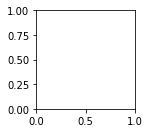

In [6]:

for iI in range(0,5):
    i = random.randint(0,len(patches))
    plt.figure(1)
    plt.subplot(1,3,1)
    plt.imshow(mosaic_patches[i])
    plt.title('Mosaic Patch')
    plt.subplot(1,3,2)
    plt.imshow(patchesLR[i])
    plt.title('LR Demosaic Patch')
    plt.subplot(1,3,3)
    plt.imshow(patches[i])
    plt.title('SR Demosaic Patch')
    plt.show()
    
    